Modelo de Clasificación de Radiografías de Tórax (Normal versus Neumonía)
El objetivo del proyecto es programar un modelo para clasificación binaria (Normal versus Neumonía) de radiografías de tórax, esta decisión se fundamente en que a día de hoy en la atención primaria en salud, este tipo de radiografía a pesar de ser uno de los más solicitados (sobretodo en época invernal) es uno de los examenes que suele no ser informado por profesional radiólogo, lo que obliga a los clínicos realizar la intepretación inicial. Considerando que dentro de los diagnósticos más relevantes es la neumonía este modelo permitiría poder realizar una clasificación inicial y rápida optimizando los recursos en atención en salud.

In [1]:
import os
import random
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
#  Descarga automática del dataset de Kaggle si no existe 
#from pathlib import Path
#import os

#DATA_ROOT = Path("data/chest_xray")  # se mantiene tu ruta
#if not DATA_ROOT.exists():
#    try:
        # instalar y autenticar Kaggle API
#        import subprocess, sys
#        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "kaggle"])
#        from kaggle.api.kaggle_api_extended import KaggleApi

#        os.makedirs("data", exist_ok=True)
#        api = KaggleApi(); api.authenticate()
#        print("Descargando dataset de Kaggle (puede tardar unos minutos)...")
#        api.dataset_download_files(
#            "paultimothymooney/chest-xray-pneumonia",
#            path="data", unzip=True
#        )
#        assert DATA_ROOT.exists(), "No se encontró la carpeta 'data/chest_xray' después de descomprimir."
#        print("Dataset descargado y listo en", DATA_ROOT)
#    except Exception as e:
#        print("No se pudo descargar automáticamente el dataset.")
#        print("Crea tu token en https://www.kaggle.com/settings/account y coloca 'kaggle.json' en ~/.kaggle/")
#        print("Error:", e)

In [3]:
# Reproducibilidad 
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Se fijan las semillas en PyTorch para que los resultados sean lo más reproducibles posible.

In [4]:
# Rutas
DATA_ROOT = Path("data/chest_xray")
TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR   = DATA_ROOT / "val"   
TEST_DIR  = DATA_ROOT / "test"
os.makedirs("artifacts", exist_ok=True)

Se definen las carpetas con su estructura ImageFolder, además se crea la carpeta artifacts/, en ella se guardará el mejor modelo y las métricas.

In [5]:
# Hiperparámetros
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 10  # N° de Épocas

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


Se definen los hiperparámetros, el modelo preentrenado ResNet18 utiliza como tamaño estándar 224 x 224. El batch de 32 representa el  número de imagenes por actualización de gradiente (compromiso entre estabilidad de gradiente y memoria GPU). Se utiliza un learning rate (LR) conservador para fine-tuning estable. Se determina el N° de épocas (10), aunque el early stopping hace el corte definitivo.
Además se determina uso de dispositivo GPU (CUDA) en caso de estar disponible para entrenamiento y evaluación más rápidos.

In [6]:
# Chequeo de estructura y conteo
def print_split_counts(root: Path):
    if not root.exists():
        print(f"{root.name} no existe.")
        return
    print(f"{root.name} folders:")
    for cls in sorted(os.listdir(root)):
        cls_path = root / cls
        if cls_path.is_dir():
            n = len(os.listdir(cls_path))
            print(f"  {cls}: {n} imágenes")

for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    print_split_counts(split_dir)

train folders:
  NORMAL: 1341 imágenes
  PNEUMONIA: 3875 imágenes
val folders:
  NORMAL: 8 imágenes
  PNEUMONIA: 8 imágenes
test folders:
  NORMAL: 234 imágenes
  PNEUMONIA: 390 imágenes


Se realiza un sanity check inicial, se recorre cada split y se reporta el N° de imágenes por clase. De esta forma es posible detectar desbalances o errores de estructuras, como carpetas vacías o clases mal nombradas.

In [7]:
# Definir transformations
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=7),
    transforms.Grayscale(num_output_channels=3), #Redes preentrenadas en ImageNet esperan 3 canales
    transforms.ToTensor(),    # Convierte a tensor y escala a [0,1] para la siguiente normalización
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

Se realiza augmentación y normalización de los datos.
La augmentación crea variaciones en los datos sin alterar la etiqueta (normal vs neumonía) de los mismos, con esto se busca reducir el sobreajuste y hacer al modelo invariante a pequeñas diferencias de adquisición o posición de la imagen, en este caso se realizan flip horizontales y leves rotaciones. Se replica el canal en 3, esto permite usar pesos preentrenados sin modificar la arquitectura.
Además se realiza normalización de los datos con las estadísticas de ImageNet (mean=[0.485, 0.456, 0.406]) y (std=[0.229, 0.224, 0.225]) mejorando la transferencia con el modelo preentrenado.

In [8]:
# Cargar datasets (ImageFolder) y crear split estratificado si no hay val/
# Dataset base de train (con transform de TRAIN)
train_base = datasets.ImageFolder(root=str(TRAIN_DIR), transform=train_tfms)
test_dataset = datasets.ImageFolder(root=str(TEST_DIR), transform=eval_tfms)

if "USE_ORIGINAL_VAL" not in globals():
    USE_ORIGINAL_VAL = False

if USE_ORIGINAL_VAL and VAL_DIR.exists():
    val_dataset   = datasets.ImageFolder(root=str(VAL_DIR), transform=eval_tfms)
    train_dataset = train_base
else:
    try:
        targets = train_base.targets
    except AttributeError:
        targets = [s[1] for s in train_base.samples]

  # Crea una validación estratificada 80/20 a partir de train/
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    idx_train, idx_val = next(sss.split(np.zeros(len(targets)), targets))

    train_dataset = Subset(train_base, idx_train)
    # Val reutiliza los paths de train pero con eval_tfms
    val_base_only_paths = datasets.ImageFolder(root=str(TRAIN_DIR), transform=eval_tfms)
    val_dataset = Subset(val_base_only_paths, idx_val)

# Chequeo de clases
classes = train_base.classes
print("Clases:", classes)  

# DataLoaders optimizados

PIN = torch.cuda.is_available()    # Se activa GPU cuando esta disponible para acelerar procesamiento.
NUM_WORKERS = 2 if os.name == "nt" else 4  

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN)

# Sanity check de un batch
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape, "Labels shape:", labels.shape)

Clases: ['NORMAL', 'PNEUMONIA']
Batch shape: torch.Size([32, 3, 224, 224]) Labels shape: torch.Size([32])


Se cargan los ImageFolder con augmentación y normalizados.
El código esta pensado para ofrecer dos alternativas de ruta, una es usar la carpeta val/ original en caso de que exista, o crear una validación estratificada 80/20 a partir de train/, esto produce una validación más robusta ya que val/ del dataset original es pequeña y menos representativa.
Aqui se crean los ImageFolder apuntando a TRAIN_DIR, uno con transforms de entrenamiento y el otro con transforms de evaluación. Ambos subconjuntos proceden de la misma carpeta, pero la validación no recibe augmentación. Al separar los datasets y transforms se evitan fugas de aleatoriedad.
Se configuran los DataLoader solo en entrenamiento (True), para romper correlaciones entre batches. 
Se incluye además un sanitu check a un batch, mostrando las formas tensoriales esperadas.

In [9]:
# Modelo (ResNet18) + pérdida con pesos de clase (robusta)
def get_train_targets(dataset, base_dataset):
    """Recupera etiquetas verdaderas del conjunto de entrenamiento (compat Subset/ImageFolder)."""
    try:
        base_targets = base_dataset.targets
    except AttributeError:
        base_targets = [s[1] for s in base_dataset.samples]
    if isinstance(dataset, Subset):
        return [base_targets[i] for i in dataset.indices]
    else:
        return base_targets

train_targets = get_train_targets(train_dataset, train_base) # Refleja las clases del split del que aprende el modelo
counts = Counter(train_targets)  # Distribución real por clases
print("Distribución de clases en train:", counts)

n0, n1 = counts.get(0, 0), counts.get(1, 0)
total = n0 + n1
w0 = total / (2.0 * n0) if n0 > 0 else 1.0
w1 = total / (2.0 * n1) if n1 > 0 else 1.0
class_weights = torch.tensor([w0, w1], dtype=torch.float32, device=device) # Se crean los pesos como un tensor
print("Pesos de clase:", class_weights)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 clases
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights) # Se define la pérdida
optimizer = optim.Adam(model.parameters(), lr=LR)

device_type = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = (device_type == "cuda")
scaler = torch.amp.GradScaler(device="cuda", enabled=use_amp) 
# ReducelRonPlateau y early stopping
try:
    scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2, verbose=True)
except TypeError:
    scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)
    print("Nota: tu PyTorch no soporta 'verbose' en ReduceLROnPlateau; lo quité.")
early_stop_patience = 3
epochs_no_improve = 0
best_f1 = -float("inf")

Distribución de clases en train: Counter({1: 3099, 0: 1073})
Pesos de clase: tensor([1.9441, 0.6731])
Nota: tu PyTorch no soporta 'verbose' en ReduceLROnPlateau; lo quité.


Este es el bloque de entrenamiento, que tiene 3 objetivos: Conocer la distribución de las clases en el conjunto de entrenamiento que se utilizará. Definir una pérdida robusta al desbalance mediante pesos de clase. Prepara un modelo ResNet18 preentrenado.
Al obtener la distribución real por clase, se calculan los pesos inversos a la frecuencia para cada clase. Esto hace que la suma de los pesos sea ≈1 por clase, y que los errores en la clase minoritaria cuentes más durante la optimización.
Luego se prepara el modelo preentrenado por lo que se aprovechan los filtros preentranados en ImageNet para texturas y bordes genéricos y se sutituye la capa final por una lineal con 2 salidas.
Se define la pérdida incorporando la ponderación por desbalance directamente en la función objetivo, elevando el gradiente de la clase infrarrepresentada.
Se utiliza GPU en caso de estar disponible para optimizar el proceso.
Se inicializa el scheduler en modo max para monitorizar la métrica que se quiere maximizar (F1 en validación)
Finalmente se configuran las variables de early stopping para cortar el entrenamiento si no hay mejoras reales en un número razonable de épocas, evitando sobreentrenar y optimizando los tiempos de entrenamiento.

ResNet18 es una red neuronal convolucional de 18 capas que resulta ser un excelente extractor de características y transfer learning, cuando se busca un equilibrio entre precisión y ligereza computacional.
https://docs.pytorch.org/vision/2.0/models/generated/torchvision.models.resnet18.html

In [10]:
# Métricas 
def get_probs_and_preds(logits: torch.Tensor):
    probs = torch.softmax(logits, dim=1)[:, 1]
    preds = torch.argmax(logits, dim=1)
    return probs, preds

def eval_loader_metrics(model, loader, device, pos_label=1, criterion=None, print_summary=False):
    model.eval()
    all_y, all_pred = [], []
    running_loss, n_samples = 0.0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            if criterion is not None:
                loss = criterion(logits, y)
                running_loss += loss.item() * x.size(0)
                n_samples += x.size(0)
            _, preds = get_probs_and_preds(logits)
            all_y.append(y.cpu()); all_pred.append(preds.cpu())

    y_true = torch.cat(all_y).numpy()
    y_pred = torch.cat(all_pred).numpy()

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=pos_label
    )
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    avg_loss = (running_loss / n_samples) if (criterion is not None and n_samples > 0) else None

    if print_summary:
        print("\n Métricas:")
        if avg_loss is not None:
            print(f"  Loss:         {avg_loss:.4f}")
        print(f"  Accuracy:     {acc:.4f}")
        print(f"  Precision:    {prec:.4f}")
        print(f"  Recall:       {rec:.4f}")
        print(f"  F1-score:     {f1:.4f}")
        print(f"  Matriz de confusión:\n{cm}")

    return {"loss": avg_loss, "acc": acc, "precision": prec, "recall": rec, "f1": f1}

Se pone el modelo en modo evaluación y se reportarn accuracy, precision, recall y F1 más la matriz de confusión.


 Métricas:
  Loss:         0.0936
  Accuracy:     0.9492
  Precision:    0.9986
  Recall:       0.9330
  F1-score:     0.9647
  Matriz de confusión:
[[267   1]
 [ 52 724]]

===== Epoch 1/10 =====
Train - Loss: 0.1326 | Acc: 0.9751 | F1: 0.9830
Val   - Loss: 0.0936 | Acc: 0.9492 | F1: 0.9647

 Métricas:
  Loss:         0.0673
  Accuracy:     0.9617
  Precision:    0.9986
  Recall:       0.9497
  F1-score:     0.9736
  Matriz de confusión:
[[267   1]
 [ 39 737]]

===== Epoch 2/10 =====
Train - Loss: 0.0584 | Acc: 0.9751 | F1: 0.9830
Val   - Loss: 0.0673 | Acc: 0.9617 | F1: 0.9736

 Métricas:
  Loss:         0.0533
  Accuracy:     0.9904
  Precision:    0.9898
  Recall:       0.9974
  F1-score:     0.9936
  Matriz de confusión:
[[260   8]
 [  2 774]]

===== Epoch 3/10 =====
Train - Loss: 0.0474 | Acc: 0.9827 | F1: 0.9885
Val   - Loss: 0.0533 | Acc: 0.9904 | F1: 0.9936

 Métricas:
  Loss:         0.0385
  Accuracy:     0.9828
  Precision:    0.9987
  Recall:       0.9781
  F1-score:     0

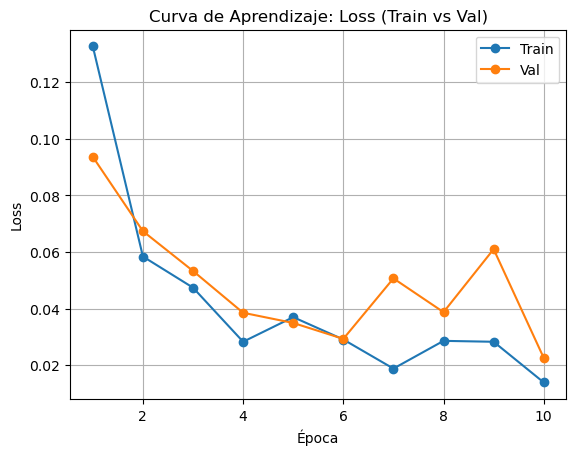

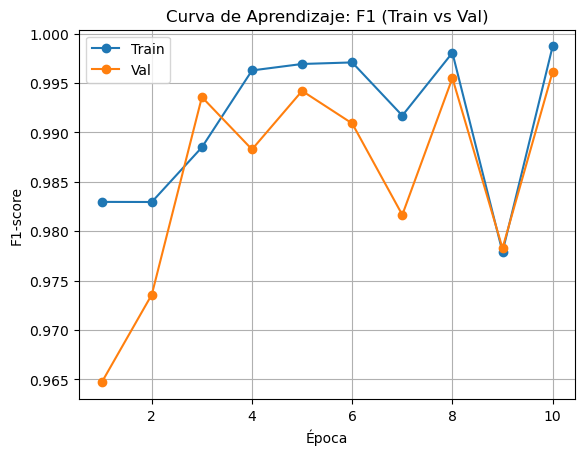

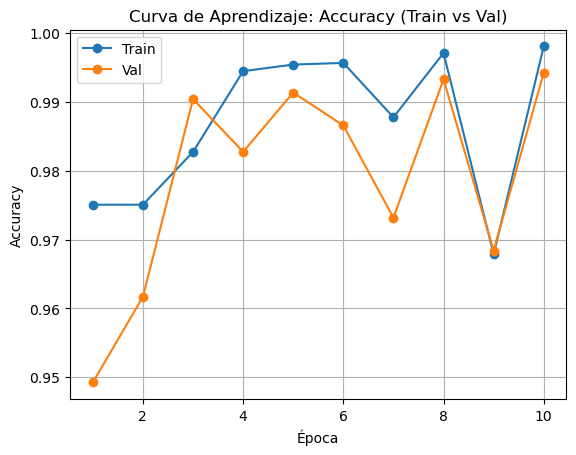

In [11]:
# Entrenamiento + registro de métricas
hist_epochs = []
hist_train_loss, hist_val_loss = [], []
hist_train_acc,  hist_val_acc  = [], []
hist_train_f1,   hist_val_f1   = [], []

best_f1 = -np.inf
use_amp = torch.cuda.is_available()
scaler  = torch.amp.GradScaler("cuda", enabled=use_amp)

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with torch.autocast(device_type=device_type, dtype=torch.float16):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * x.size(0)

    train_loss_epoch = running_loss / len(train_loader.dataset)
    train_metrics = eval_loader_metrics(model, train_loader, device, criterion=criterion, print_summary=False)
    val_metrics   = eval_loader_metrics(model,   val_loader, device, criterion=criterion, print_summary=True)

    # ===== Log / historiales =====
    hist_epochs.append(epoch)

    # Loss: para train se utiliza el calculado en el loop; para val el de eval
    hist_train_loss.append(train_loss_epoch)
    hist_val_loss.append(val_metrics["loss"])

    # Acc y F1 de train/val
    hist_train_acc.append(train_metrics["acc"])
    hist_val_acc.append(val_metrics["acc"])
    hist_train_f1.append(train_metrics["f1"])
    hist_val_f1.append(val_metrics["f1"])

    # Guardar mejor modelo por F1 de validación
    if val_metrics["f1"] > best_f1:
        best_f1 = val_metrics["f1"]
        torch.save(model.state_dict(), "artifacts/best_model_resnet18.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Scheduler sobre F1 de validación
    scheduler.step(val_metrics["f1"])

    print(f"\n===== Epoch {epoch}/{EPOCHS} =====")
    print(f"Train - Loss: {train_loss_epoch:.4f} | Acc: {train_metrics['acc']:.4f} | F1: {train_metrics['f1']:.4f}")
    print(f"Val   - Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['acc']:.4f} | F1: {val_metrics['f1']:.4f}")


    # Early stopping
    if epochs_no_improve >= early_stop_patience:
        print(f" Early stopping: {early_stop_patience} épocas sin mejorar F1 en validación.")
        break

# Gráficos de curvas de aprendizaje (1 métrica por figura)

# Loss train vs val
plt.figure()
plt.plot(hist_epochs, hist_train_loss, marker='o', label='Train')
plt.plot(hist_epochs, hist_val_loss,   marker='o', label='Val')
plt.xlabel("Época"); plt.ylabel("Loss")
plt.title("Curva de Aprendizaje: Loss (Train vs Val)")
plt.grid(True); plt.legend(); plt.show()

# F1 train vs val
plt.figure()
plt.plot(hist_epochs, hist_train_f1, marker='o', label='Train')
plt.plot(hist_epochs, hist_val_f1,   marker='o', label='Val')
plt.xlabel("Época"); plt.ylabel("F1-score")
plt.title("Curva de Aprendizaje: F1 (Train vs Val)")
plt.grid(True); plt.legend(); plt.show()

# Accuracy train vs val
plt.figure()
plt.plot(hist_epochs, hist_train_acc, marker='o', label='Train')
plt.plot(hist_epochs, hist_val_acc,   marker='o', label='Val')
plt.xlabel("Época"); plt.ylabel("Accuracy")
plt.title("Curva de Aprendizaje: Accuracy (Train vs Val)")
plt.grid(True); plt.legend(); plt.show()

In [12]:
def collect_probs_preds(model, loader, device):
    model.eval()
    ys, preds, probs = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            p  = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            pr = torch.argmax(logits, dim=1).cpu().numpy()
            ys.append(y.numpy()); preds.append(pr); probs.append(p)
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(preds)
    y_prob = np.concatenate(probs)
    return y_true, y_pred, y_prob

def plot_confusion(y_true, y_pred, labels=None, normalize='true'):
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=labels, normalize=normalize, ax=ax
    )
    ax.set_title("Matriz de confusión (normalizada)")
    plt.grid(False)
    plt.show()

Cargado checkpoint: artifacts/best_model_resnet18.pth

=== TEST ===
Accuracy: 0.8205  Precision: 0.7791  Recall: 0.9949  F1: 0.8739


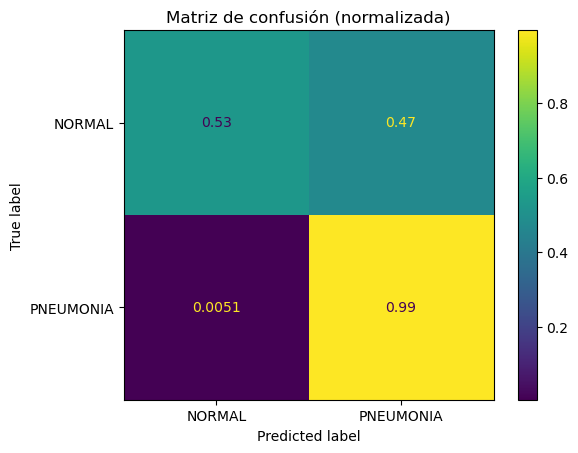

In [13]:
#  Evaluación final en TEST

# Carga mejor versión del modelo
best_path = "artifacts/best_model_resnet18.pth"
if os.path.exists(best_path):
    model.load_state_dict(torch.load(best_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Cargado checkpoint: {best_path}")
else:
    print("Aviso: no se encontró el checkpoint; se evaluará el último estado del modelo.")
    model.eval()

y_true, y_pred, y_prob = collect_probs_preds(model, test_loader, device)
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")

print("\n=== TEST ===")
print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")

plot_confusion(y_true, y_pred, classes)

# Guardar reporte csv simple

pd.DataFrame([{"split":"test","accuracy":acc,"precision":prec,"recall":rec,"f1":f1}]).to_csv("artifacts/test_metrics.csv", index=False)